In [1]:
import pandas as pd
import numpy as np

#Plots
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
#Nicer style
style.use('seaborn') 

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

#Work with text
from nltk.tokenize import RegexpTokenizer
import re #regexp
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 




#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

import random

# Fake news corpus
## Descripción del dataset

El dataset descargado es [Fake News Corpus](https://github.com/several27/FakeNewsCorpus). 
Este es un dataset abierto que se sigue actualizando dirariamente en base a los datos de [OpenSources.co](http://www.opensources.co/), que es una lista de noticias etiquetadas por un equipo de investigadores de la Univerisdad Merrimack. Hay 12 categorías y son las siguientes:

* **Fake News (tag fake)** Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports

* **Satire (tag satire)** Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events.

* **Extreme Bias (tag bias)** Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts.

* **Conspiracy Theory (tag conspiracy):** Sources that are well-known promoters of kooky conspiracy theories.

* **Rumor Mill (tag rumor)** Sources that traffic in rumors, gossip, innuendo, and unverified claims.

* **State News (tag state)** Sources in repressive states operating under government sanction.

* **Junk Science (tag junksci)** Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims.

* **Hate News (tag hate)** Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination.

* **Clickbait (tag clickbait)** Sources that provide generally credible content, but use exaggerated, misleading, or questionable headlines, social media descriptions, and/or images.

* **Proceed With Caution (tag unreliable)** Sources that may be reliable but whose contents require further verification.

* **Political (tag political)** Sources that provide generally verifiable information in support of certain points of view or political orientations.

* **Credible (tag reliable)** Sources that circulate news and information in a manner consistent with traditional and ethical practices in journalism (Remember: even credible sources sometimes rely on clickbait-style headlines or occasionally make mistakes. No news organization is perfect, which is why a healthy news diet consists of multiple sources of information).

La versión usada en este trabajo tiene **8.529.194 entradas** y pesa **27GB**


### Cargamos las primeras 20.000 filas del dataset.

In [2]:
news = pd.read_csv('../data/news_sampled.csv', nrows=20000)
#Select only relevant columns
news = news[['type', 'content', 'title']]
#Remove columns with NaNs 
news = news.dropna()

*Convertir tags la división usada*

In [3]:
def convert_tag(tag):
    """Convierte un tag a uno de tres grupos (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'unreliable', 'fake'])
    truth = set(['reliable', 'political'])
    click = set(['clickbait'])
    bias = set(['bias'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    if tag in click:
        new_tag = 'click'
    if tag in bias:
        new_tag = 'bias'
        
    return new_tag

In [4]:
news['type'] = news.swifter.apply(lambda row: convert_tag(row['type']), axis=1)

Pandas Apply: 100%|██████████| 19275/19275 [00:00<00:00, 66230.74it/s]


In [5]:
news.head(3)

,type,content,title
0,fake,"Life is an illusion, at least on a quantum lev...",Is life an ILLUSION? Researchers prove 'realit...
1,fake,"“When the police finally left the campus, arou...",Black Agenda Report
2,fake,\n\nSpeaking Engagement Request\n\n\n\nContact...,Request Speaking Engagement


### Número de noticias por tipo

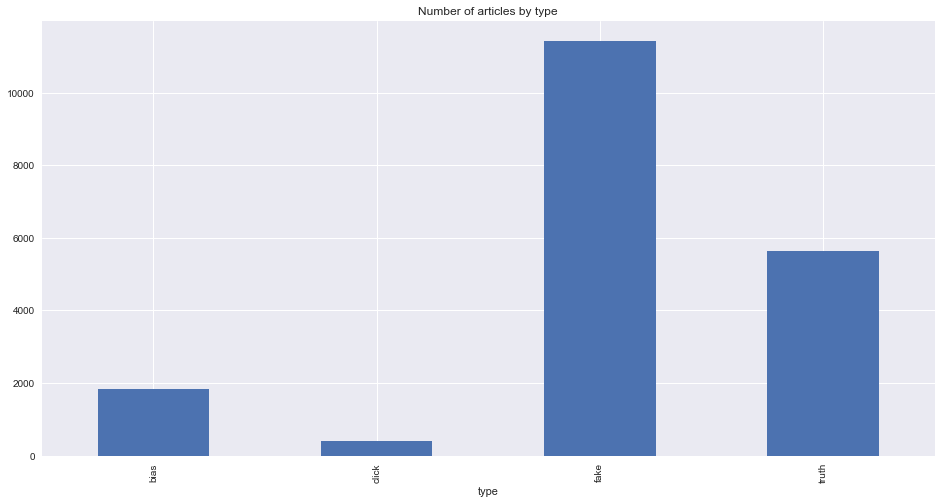

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

El grupo fake está claramente sobrerrepresentado en el dataset, mientras que el que menos elementos tiene es el grupo *clickbait*

# Análisis lingüístico

Funciones auxiliares

In [43]:
stop_words = STOPWORDS.union(set(["will"]))
ps = PorterStemmer()

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]    
    
    return ' '.join(words)


def clean_text_array(text):
    """ Lo mismo que clean_text pero retorna un array
    """
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words


def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens


def split_phrases(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = '. '.join(text.split("\n")).split(".")
    text = [x for x in text if x not in [".", "\n", "", " "]]
    return text

### Palabras más frecuentes por tipo de noticia

#### En el título

In [8]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'click']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_click = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'truth']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'bias']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_bias= c.most_common(20)

In [9]:
most_common_bias

[('link', 234),
 ('pages', 233),
 ('us', 82),
 ('changes', 70),
 ('related', 70),
 ('conservapedia', 58),
 ('talk', 55),
 ('trump', 47),
 ('page', 39),
 ('russia', 37),
 ('obama', 37),
 ('new', 37),
 ('category', 36),
 ('antiwar', 33),
 ('user', 33),
 ('home', 31),
 ('archived', 30),
 ('news', 26),
 ('uk', 25),
 ('security', 24)]

In [10]:
most_common_truth

[('daily', 530),
 ('kos', 474),
 ('trump', 428),
 ('articles', 361),
 ('profile', 236),
 ('obama', 158),
 ('new', 132),
 ('news', 117),
 ('people', 107),
 ('gop', 104),
 ('house', 98),
 ('comments', 98),
 ('followed', 88),
 ('bill', 86),
 ('archives', 84),
 ('senate', 79),
 ('tax', 72),
 ('state', 71),
 ('democrats', 71),
 ('global', 69)]

In [11]:
most_common_fake

[('new', 468),
 ('trump', 323),
 ('market', 308),
 ('us', 254),
 ('news', 240),
 ('obama', 199),
 ('america', 190),
 ('video', 188),
 ('world', 188),
 ('report', 175),
 ('global', 163),
 ('u', 162),
 ('war', 152),
 ('now', 146),
 ('one', 142),
 ('time', 131),
 ('year', 125),
 ('act', 123),
 ('first', 122),
 ('people', 121)]

In [12]:
most_common_click

[('portal', 142),
 ('trump', 75),
 ('archives', 65),
 ('donald', 15),
 ('clinton', 8),
 ('new', 7),
 ('twitter', 6),
 ('sanders', 6),
 ('video', 6),
 ('obama', 6),
 ('hillary', 6),
 ('black', 6),
 ('one', 5),
 ('makes', 5),
 ('going', 5),
 ('man', 5),
 ('anti', 5),
 ('got', 5),
 ('school', 5),
 ('fox', 5)]

__Análisis de tri-grams__

In [13]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [14]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'truth']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [15]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'click']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_click = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_click[ng_text] = ng_count

In [16]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'bias']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_bias = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_bias[ng_text] = ng_count

In [17]:
print("TRIGRAMS BIAS")
ngrams_bias

TRIGRAMS BIAS


{'that link to': 233,
 'pages that link': 233,
 'changes related to': 70,
 'home page from': 30,
 'archived antiwar home': 30,
 'antiwar home page': 30,
 'user contributions for': 15,
 'for security policy': 13,
 'center for security': 13,
 'archives oath keepers': 10,
 'all public logs': 10,
 'page from march': 8,
 'page from january': 7,
 'page from february': 7,
 'link to of': 7,
 'vdare premier news': 6,
 'related to of': 6,
 'premier news outlet': 6,
 'patriotic immigration reform': 6,
 'outlet for patriotic': 6,
 'news outlet for': 6,
 'for patriotic immigration': 6,
 'page conservapedia breaking': 5,
 'link to and': 5,
 'conservapedia breaking news': 5,
 'anatoly karlin archive': 5,
 'the unz review': 4,
 'page from december': 4,
 'page from april': 4,
 'link to talk': 4}

In [18]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'daily kos comments': 87,
 'kos comments by': 80,
 'the daily caller': 62,
 'baptist news global': 55,
 'posting history for': 47,
 'at daily kos': 35,
 'archives page of': 24,
 'kos blogroll for': 23,
 'daily kos blogroll': 23,
 'author at breitbart': 15,
 'tech at night': 14,
 'overnight news digest': 11,
 'national review online': 10,
 'new york times': 8,
 'kos comments rated': 7,
 'daily kos elections': 7,
 'comments rated by': 7,
 'the end of': 6,
 'guardian liberty voice': 6,
 'archives baptist news': 6,
 'the white house': 5,
 'the new york': 5,
 'the difference between': 5,
 'street prophets coffee': 5,
 'prophets coffee hour': 5,
 'on christian post': 5,
 'of baptist news': 5,
 'news on christian': 5,
 'march for life': 5,
 'in new hampshire': 5}

In [19]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'articles and information': 81,
 'news articles and': 78,
 'stories contributed by': 28,
 'page awareness act': 21,
 'the united states': 20,
 'strategic culture foundation': 20,
 'trading watch list': 18,
 'market research report': 18,
 'cooking and recipes': 18,
 'of the year': 17,
 'the truth about': 15,
 'you need to': 14,
 'science and technology': 14,
 'of the day': 14,
 'how to make': 14,
 'and forecast to': 14,
 'new at reason': 13,
 'through my bible': 12,
 'small cap value': 12,
 'cap value report': 12,
 'trends and forecast': 11,
 'the podesta emails': 11,
 'responsorial psalm psalms': 11,
 'my bible yr': 11,
 'family security matters': 11,
 'author at break': 11,
 'at break point': 11,
 'why you should': 10,
 'to know about': 10,
 'the institute for': 10}

In [20]:
print("TRIGRAMS CLICK")
ngrams_click

TRIGRAMS CLICK


{'voter fraud commission': 2,
 'trump voter fraud': 2,
 'to stop trump': 2,
 'the christian right': 2,
 'stop trump voter': 2,
 'soros groups fight': 2,
 'politicususa editorial archives': 2,
 'of the day': 2,
 'just in trump': 2,
 'jeff flake for': 2,
 'is going to': 2,
 'if clinton wins': 2,
 'groups fight to': 2,
 'fight to stop': 2,
 'donald trump archives': 2,
 'did bernie sanders': 2,
 'against trump archives': 2,
 'young turks archives': 1,
 'young mother with': 1,
 'young children in': 1,
 'young black men': 1,
 'you won believe': 1,
 'you will never': 1,
 'you not alone': 1,
 'you never guess': 1,
 'you may start': 1,
 'you hate most': 1,
 'you for your': 1,
 'you feeling vaguely': 1,
 'you be the': 1}

**Wordclouds for titles**

Text(0.5,1,"WordCloud for 'truth'")

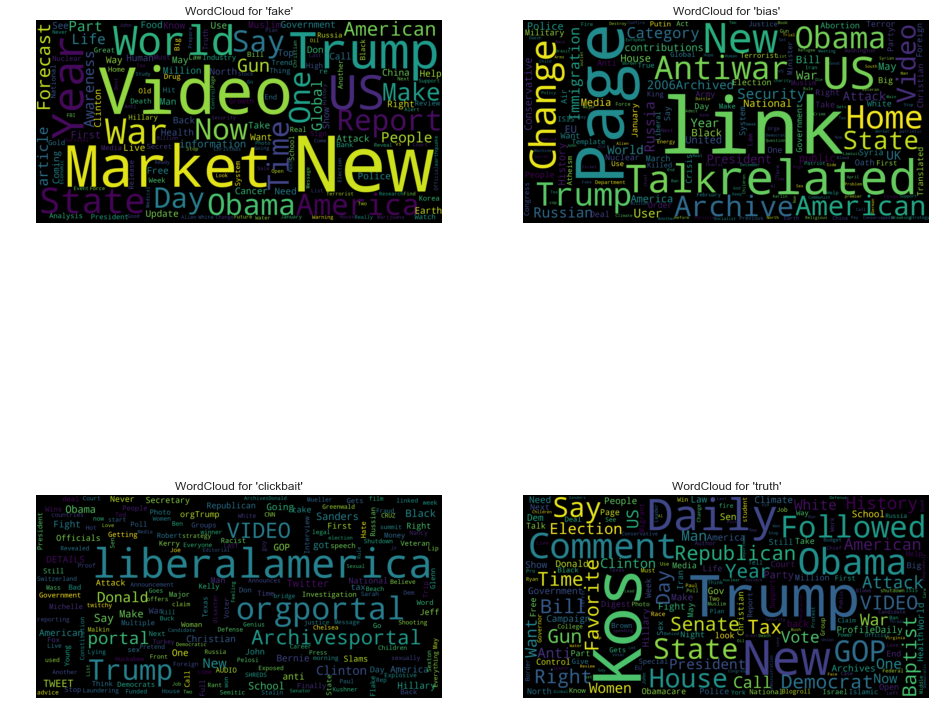

In [21]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,0].imshow(wordcloud, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title("WordCloud for 'fake'")




corpus_text = ''.join(news[news['type'] == 'bias']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,1].imshow(wordcloud, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title("WordCloud for 'bias'")


corpus_text = ''.join(news[news['type'] == 'click']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,0].imshow(wordcloud, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title("WordCloud for 'clickbait'")


corpus_text = ''.join(news[news['type'] == 'truth']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,1].imshow(wordcloud, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title("WordCloud for 'truth'")

### En el contenido
#### Palabras más usadas

In [22]:
stop_words = STOPWORDS.union(set(["will", "one", "new"])) #Most common words in all

In [23]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'click']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_click = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'truth']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'bias']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_bias= c.most_common(20)

In [24]:
most_common_bias

[('talk', 3768),
 ('said', 2020),
 ('us', 1893),
 ('people', 1866),
 ('government', 1423),
 ('american', 1285),
 ('first', 1278),
 ('president', 1273),
 ('even', 1243),
 ('states', 1229),
 ('state', 1221),
 ('now', 1201),
 ('war', 1149),
 ('obama', 1130),
 ('world', 1070),
 ('time', 1061),
 ('many', 1041),
 ('trump', 1031),
 ('years', 1030),
 ('conservapedia', 1025)]

In [25]:
most_common_truth

[('trump', 9499),
 ('said', 7257),
 ('recs', 7154),
 ('people', 6510),
 ('president', 6391),
 ('state', 5773),
 ('now', 4712),
 ('time', 4670),
 ('u', 4372),
 ('house', 4070),
 ('even', 4029),
 ('first', 3899),
 ('government', 3894),
 ('obama', 3866),
 ('two', 3734),
 ('years', 3678),
 ('american', 3674),
 ('last', 3670),
 ('us', 3597),
 ('many', 3544)]

In [26]:
most_common_fake

[('blockchain', 15801),
 ('people', 14483),
 ('trump', 13292),
 ('us', 12144),
 ('time', 10920),
 ('next', 10575),
 ('now', 9667),
 ('said', 9259),
 ('two', 9192),
 ('many', 8868),
 ('bitcoin', 8653),
 ('world', 8652),
 ('stocks', 8505),
 ('even', 8225),
 ('market', 8009),
 ('headline', 7986),
 ('searches', 7930),
 ('exceed', 7928),
 ('may', 7547),
 ('first', 7539)]

In [27]:
most_common_click

[('trump', 1401),
 ('donald', 475),
 ('president', 442),
 ('people', 364),
 ('said', 295),
 ('now', 229),
 ('republican', 220),
 ('white', 216),
 ('time', 213),
 ('news', 213),
 ('twitter', 212),
 ('clinton', 209),
 ('january', 208),
 ('house', 207),
 ('state', 206),
 ('right', 206),
 ('even', 203),
 ('know', 187),
 ('us', 177),
 ('government', 173)]

#### Tri-grams más usados

In [28]:
news_lite = news.head(2000) #Version reducida para que no tarde tanto

In [30]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'fake']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [31]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'truth']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [32]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'click']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_click = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_click[ng_text] = ng_count

In [33]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'bias']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_bias = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_bias[ng_text] = ng_count

In [34]:
print("TRIGRAMS BIAS")
ngrams_bias

TRIGRAMS BIAS


{'of planned parenthood': 23,
 'the holy spirit': 14,
 'your supernatural lifestyle': 12,
 'your head and': 12,
 'you read his': 12,
 'you in his': 12,
 'word select bibles': 12,
 'with god in': 12,
 'way as you': 12,
 'war in your': 12,
 'unlock your supernatural': 12,
 'this article send': 12,
 'the war in': 12,
 'the spirit series': 12,
 'the life in': 12,
 'the bibles encounter': 12,
 'that saturates you': 12,
 'supernatural lifestyle click': 12,
 'spirit series free': 12,
 'spirit and develop': 12,
 'show me the': 12,
 'shipping and free': 12,
 'series free gift': 12,
 'send us correction': 12,
 'select bibles are': 12,
 'see an error': 12,
 'saturates you in': 12,
 'relationship that saturates': 12,
 'read his word': 12,
 'plus free shipping': 12}

In [35]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'the united states': 55,
 'the white house': 49,
 'one of the': 43,
 'according to the': 34,
 'the washington examiner': 32,
 'the trump administration': 31,
 'the christian post': 28,
 'as well as': 28,
 'the supreme court': 27,
 'part of the': 24,
 'march for life': 24,
 'in order to': 24,
 'first baptist church': 24,
 'qc family tree': 23,
 'we need to': 22,
 'in the united': 22,
 'be able to': 21,
 'some of the': 20,
 'president of the': 18,
 'of the christian': 18,
 'those of the': 17,
 'president donald trump': 17,
 'new york times': 17,
 'in the senate': 17,
 'to talk about': 16,
 'the views of': 16,
 'the fact that': 16,
 'can you feel': 16,
 'voices do not': 15,
 'views of the': 15}

In [36]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'the united states': 730,
 'trump blockchain stocks': 638,
 'stocks are next': 638,
 'searches exceed trump': 638,
 'headline bitcoin blockchain': 638,
 'exceed trump blockchain': 638,
 'blockchain stocks are': 638,
 'blockchain searches exceed': 638,
 'bitcoin blockchain searches': 638,
 'one of the': 467,
 'this story is': 277,
 'your two cents': 275,
 'add your two': 275,
 'think this story': 274,
 'story is fact': 274,
 'readers think this': 274,
 'of readers think': 274,
 'is fact add': 274,
 'fact add your': 274,
 'two cents headline': 269,
 'cents headline bitcoin': 269,
 'as well as': 257,
 'the right to': 249,
 'in order to': 218,
 'canada free press': 210,
 'of the united': 208,
 'the fact that': 197,
 'to canada free': 194,
 'subscribe to canada': 194,
 'press for free': 194}

In [37]:
print("TRIGRAMS CLICK")
ngrams_click

TRIGRAMS CLICK


{'the united states': 13,
 'the white house': 12,
 'the trump administration': 12,
 'according to the': 12,
 'featured image via': 10,
 'via getty images': 6,
 'new york times': 6,
 'image via getty': 6,
 'featured image by': 6,
 'the washington post': 5,
 'the trump campaign': 5,
 'the new york': 5,
 'the case of': 5,
 'of the united': 5,
 'in the case': 5,
 'donald trump january': 5,
 'they not sending': 4,
 'the united kingdom': 4,
 'the supreme court': 4,
 'the obama administration': 4,
 'the government shutdown': 4,
 'the first time': 4,
 'the end of': 4,
 'that they are': 4,
 'that he was': 4,
 'of the trump': 4,
 'of the state': 4,
 'in the world': 4,
 'ice jam flooding': 4,
 'you look at': 3}

Text(0.5,1,"WordCloud for 'truth'")

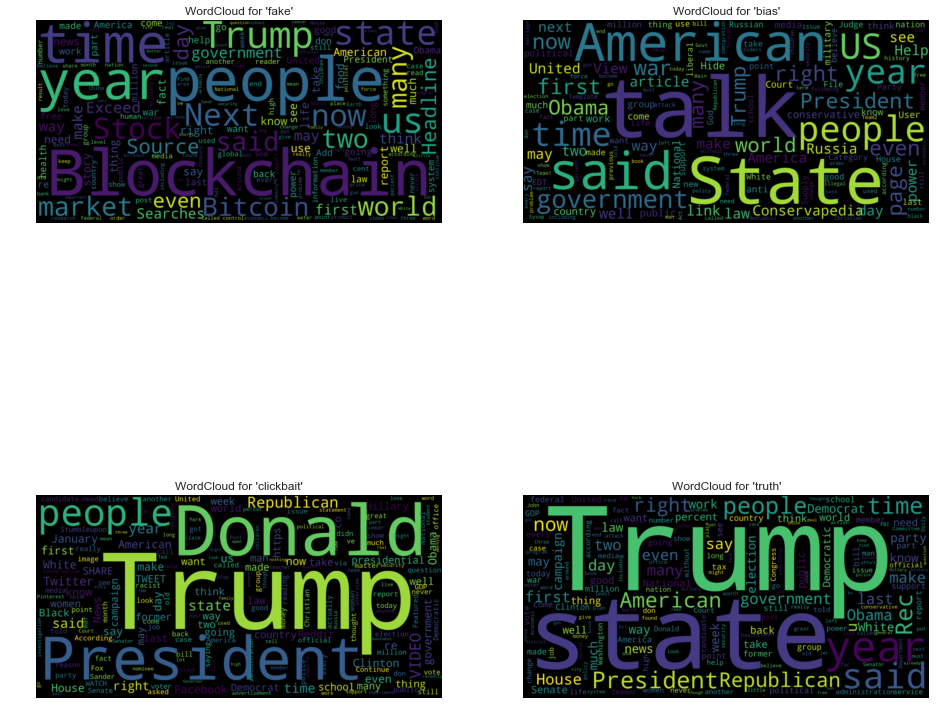

In [38]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,0].imshow(wordcloud, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title("WordCloud for 'fake'")




corpus_text = ''.join(news[news['type'] == 'bias']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,1].imshow(wordcloud, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title("WordCloud for 'bias'")


corpus_text = ''.join(news[news['type'] == 'click']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,0].imshow(wordcloud, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title("WordCloud for 'clickbait'")


corpus_text = ''.join(news[news['type'] == 'truth']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,1].imshow(wordcloud, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title("WordCloud for 'truth'")

**Longitud en palabras de las noticias**

Para ello, hay que tokenizar y limpiar el texto

In [39]:
news['clean_content'] = news.swifter.apply(lambda row: clean_text(row['content']), axis=1)
news['clean_title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

Pandas Apply: 100%|██████████| 19275/19275 [00:00<00:00, 33976.91it/s]


In [40]:
news['len_content'] = news.swifter.apply(lambda row: len(row['clean_content']), axis=1)

Pandas Apply: 100%|██████████| 19275/19275 [00:00<00:00, 64249.55it/s]


Text(0.5,0.98,'')

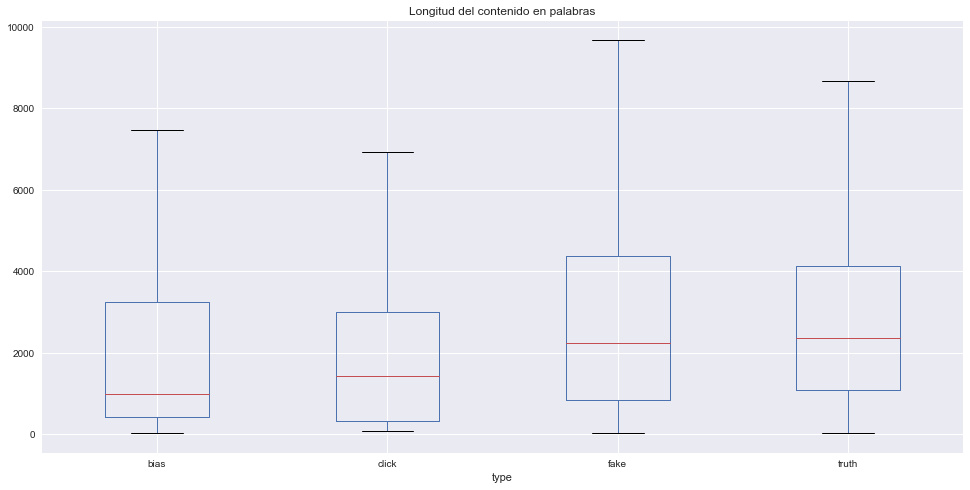

In [41]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Longitud del contenido en palabras")
plt.suptitle("")

In [42]:
news = news.drop(["clean_content", "clean_title","len_content"], axis=1)

**Longitud media de las frases**



In [44]:
corpus_text = '. '.join([i for i in news[news['type'] == 'fake']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_fake = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'truth']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_truth = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'click']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_click = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'bias']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_bias = [len(tokenize(s)) for s in corpus_text]

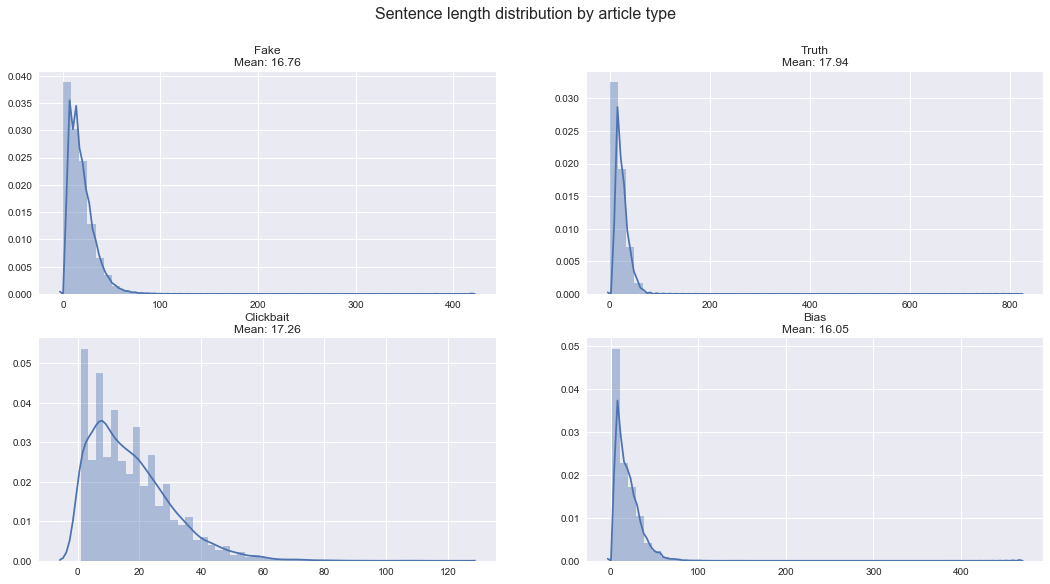

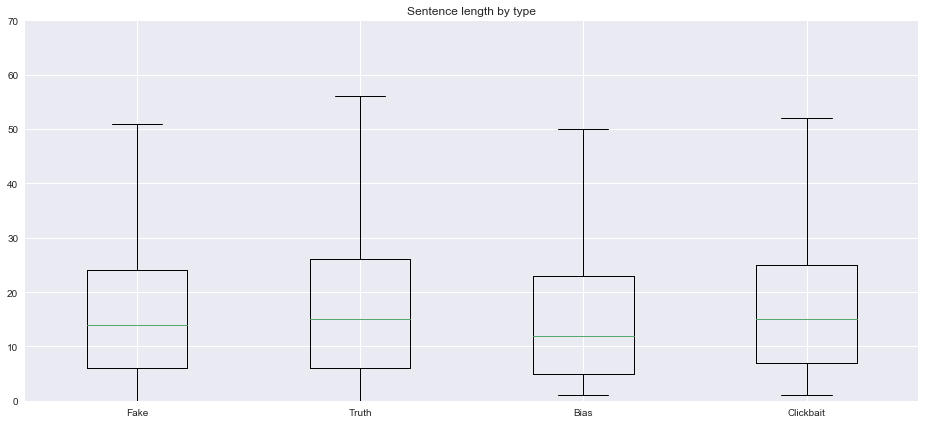

In [45]:
fig, ax = plt.subplots(2,2, figsize=(18,9))
fig.suptitle("Sentence length distribution by article type", size=16)

sns.distplot(lengths_fake, ax=ax[0,0])
ax[0,0].set_title("Fake\nMean: {0:.2f}".format(np.average(lengths_fake)))


sns.distplot(lengths_truth, ax=ax[0,1])
ax[0,1].set_title("Truth\nMean: {0:.2f}".format(np.average(lengths_truth)))

sns.distplot(lengths_click, ax=ax[1,0])
ax[1,0].set_title("Clickbait\nMean: {0:.2f}".format(np.average(lengths_click)))

sns.distplot(lengths_bias, ax=ax[1,1])
ax[1,1].set_title("Bias\nMean: {0:.2f}".format(np.average(lengths_bias)))

plt.show()


#Boxplot
fig, ax = plt.subplots(1,1, figsize=(16,7))
plt.title("Sentence length by type")
plt.ylim((0,70))
plt.boxplot([lengths_fake, lengths_truth, lengths_bias, lengths_click], 
            labels=['Fake', 'Truth', 'Bias', 'Clickbait'])
plt.show()

**Longitud en frases de las noticias**

In [46]:
news['len_content'] = news.swifter.apply(lambda row: len(row['content'].split(". ")), axis=1)

Pandas Apply: 100%|██████████| 19275/19275 [00:00<00:00, 41114.65it/s]


Text(0.5,0.98,'')

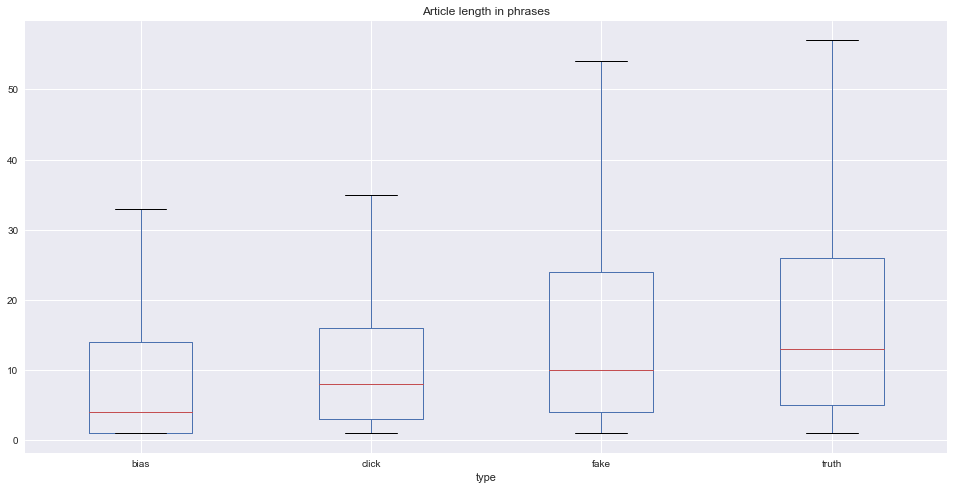

In [47]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Article length in phrases")
plt.suptitle("")

**Signos de exclamación/interrogación por tipos de noticias**

In [48]:
news['len_content'] = news.content.str.count("!|\?")

Text(0.5,0.98,'')

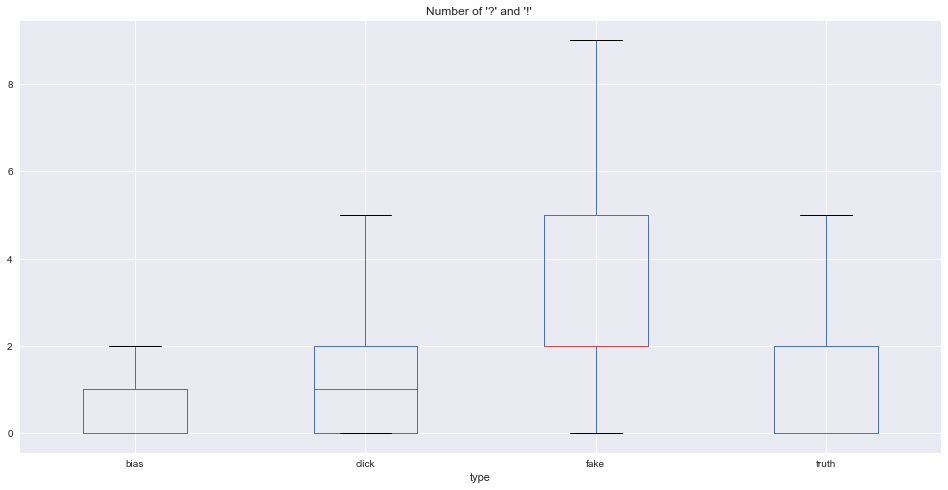

In [49]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Number of '?' and '!' ")
plt.suptitle("")

In [62]:
news=news.drop(['len_content'], axis=1)

## Análisis psicológico

Analizar las noticias por uso de personas:

* Primera persona: *I, me, my, mine, we, usk our, ours*
* Segunda persona: *you, you, your, yours*
* Tercera persona: *he, she, his, her, him, his, hers, they, them, their, theirs*

In [63]:
def count_person_forms(text, person):
    """
    Cuenta las ocurrencias de los tokens de person en el texto
    """
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter       

Pandas Apply: 100%|██████████| 19275/19275 [00:06<00:00, 3079.11it/s]


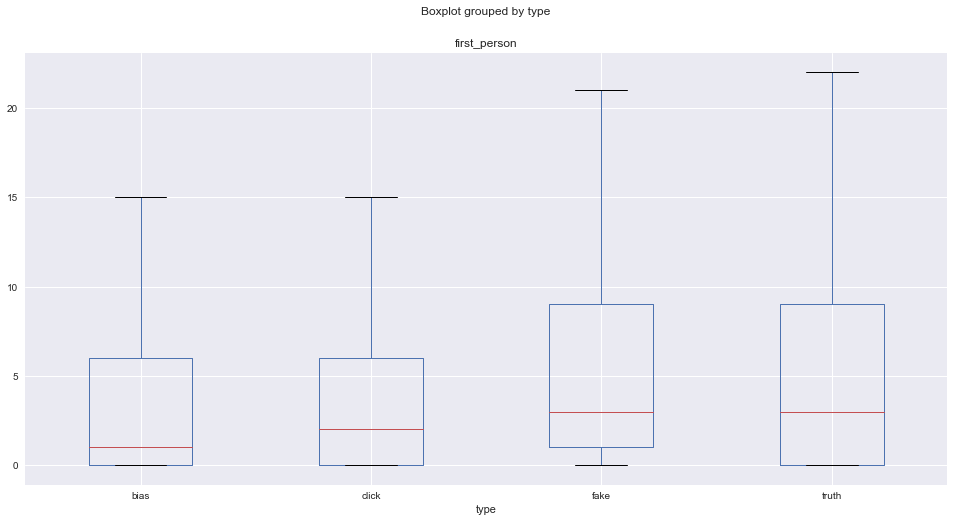

In [70]:
first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
second_person = ["you", "your", "yours"]

news['first_person'] = news.swifter.apply(lambda row: count_person_forms(row['content'], first_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['first_person'], by='type', ax=ax, showfliers=False)
plt.show()

In [71]:
news.groupby('type')['first_person'].mean()

type
bias     6.454151
click    4.555270
fake     8.158928
truth    7.841180
Name: first_person, dtype: float64

Pandas Apply: 100%|██████████| 19275/19275 [00:05<00:00, 3535.30it/s]


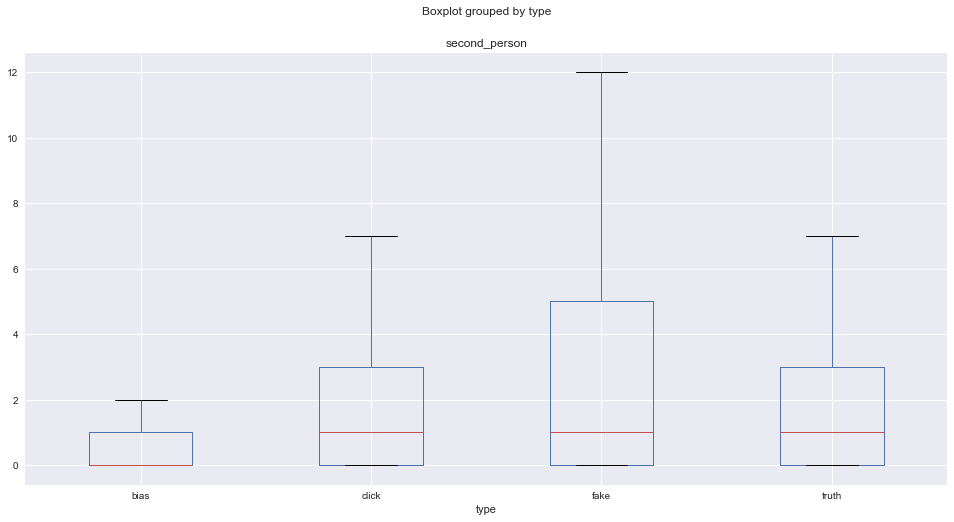

In [72]:
news['second_person'] = news.swifter.apply(lambda row: count_person_forms(row['content'], second_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['second_person'], by='type', ax=ax, showfliers=False)
plt.show()

In [73]:
news=news.drop(['first_person'], axis=1)
news=news.drop(['second_person'], axis=1)

## Análisis de sentimiento

In [74]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [75]:
def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

In [76]:
news['sent'] = news.swifter.apply(lambda r: classify_sentiment(r['content']), axis=1)

Pandas Apply: 100%|██████████| 19275/19275 [04:30<00:00, 71.21it/s]


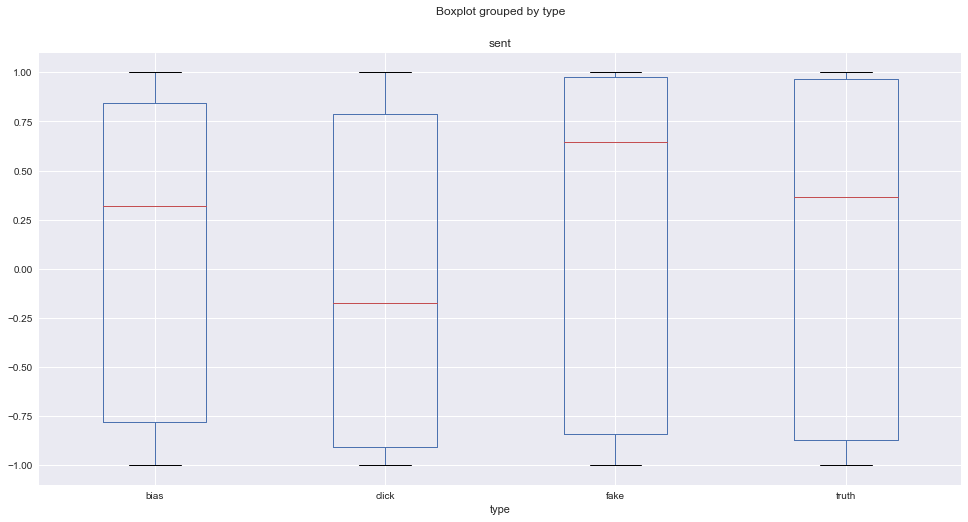

In [77]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['sent'], by='type', ax=ax, showfliers=False)

plt.show()

## Análisis de diversidad de vocabulario

$ l = \frac {|t|}{|T|}$

Siendo
* $t$ el texto
* $T$ el conjunto de palabras (sin repetición) en el texto

In [82]:
def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

In [83]:
news['lexical_diver'] = news.swifter.apply(lambda r: lexical_diversity(r['content']), axis=1)

Pandas Apply: 100%|██████████| 19275/19275 [00:05<00:00, 3592.17it/s]


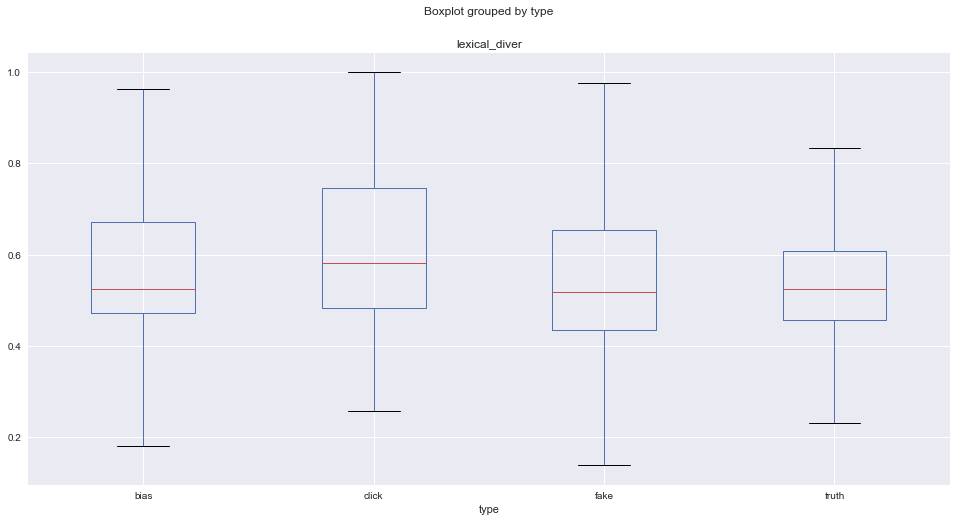

In [84]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['lexical_diver'], by='type', ax=ax, showfliers=False)
plt.show()

In [85]:
news.groupby('type')['lexical_diver'].mean()

type
bias     0.570172
click    0.611938
fake     0.553289
truth    0.553283
Name: lexical_diver, dtype: float64